In [34]:
import baltic as bt
import pandas as pd
import json
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
from collections import Counter
import re
import sys
import dendropy


module_dir = "/Users/monclalab1/Documents/scripts/"
sys.path.append(module_dir)

from fasta_editing import fasta_to_df, fasta_writer

list_of_genes = ["ha", "pb2","pb1","na","np","pa","ns","mp"] 

In [36]:
# tree input cannot have commas between reassorting segments or it wont parse correctly

''' 
1. replaces commas with "-" (where the reassorted segments are inferred)
2. remove the single quotation marks around NODE_####
3. replaces ? with _ (where there is an undetermined reassortment event)
4. converts to nwk
    
'''

def treesort_QC(qc_input, qc_output):
    
    with open(qc_input, 'r') as file:
        modified = file.read()
        
    start_idx = modified.find('(')
    modified = modified[start_idx:]
    
    end_idx = modified.find('END;')
    modified = modified[:end_idx]
        
    # removing commas between segments
    modified = re.sub(r'rea="([^"]+)"', lambda match: f'rea="{match.group(1).replace(",", "-")}"', modified)

    # removing quotation marks around node names
    modified = re.sub(r"'(NODE_\d+)'", r'\1', modified)
    
    # replacing ? with _ so baltic can read it in
    modified = modified.replace('?', '_')
    
    
    with open(qc_output, "w") as output_file:
        output_file.write(modified.strip())


treesort_QC("prepped/div/outputs/output3.tree", "prepped/div/outputs/output3_QC.nwk")

In [37]:
tree = dendropy.Tree.get(
    path='prepped/div/outputs/output3_QC.nwk',
    schema="newick",
    preserve_underscores=True
)

node_annotations_summary = {}

for node in tree.preorder_node_iter():
    if not node.label:
        node_name = str(node.taxon)
    else:
        node_name = node.label
    
    reassorted_count = 0
    nonreassorted_count = 0
    rea_dict = {}
    
    for a in node.annotations:
        name = a.name
        value = str(a.value)
        
        if name == 'is_reassorted':
            if value == '1':
                reassorted_count += 1
            elif value == '0':
                nonreassorted_count += 1
        elif name == 'rea':
            if value in rea_dict:
                rea_dict[value] += 1
            else:
                rea_dict[value] = 1
    
    node_annotations_summary[node_name] = {
        'reassorted': reassorted_count,
        'nonreassorted': nonreassorted_count,
        'rea': rea_dict
    }



In [38]:
 # for label, summary in node_annotations_summary.items():
 #    print(label, summary)

In [39]:
# making "mcc" tree

for node in tree.preorder_node_iter():
    
    label = str(node.taxon) if node.is_leaf() else node.label
    
    if label in node_annotations_summary:
        
        info = node_annotations_summary[label]
        node.annotations.clear()
        
        # what if there were 2 events, 2 different rea annotations? need to account for that
        is_reassorted = 1 if info["reassorted"] >= 2 else 0
        node.annotations.add_new("is_reassorted", is_reassorted)
        
        if is_reassorted and info["rea"]:
            majority_rea = max(info["rea"].items(), key=lambda x: x[1])[0]
            node.annotations.add_new("rea", majority_rea)
        

# for some reason only nexus trees with annotations are able to be read in by figtree
tree.write(path="prepped/div/outputs/output3_summary.nexus", schema="nexus", suppress_annotations = False)

tree.write(path="prepped/div/outputs/output3_summary.nwk", schema="newick", suppress_annotations = False)

# need summary nwk tree to be readable by baltic
treesort_QC("prepped/div/outputs/output3_summary.nwk", "prepped/div/outputs/output3_summary.nwk")

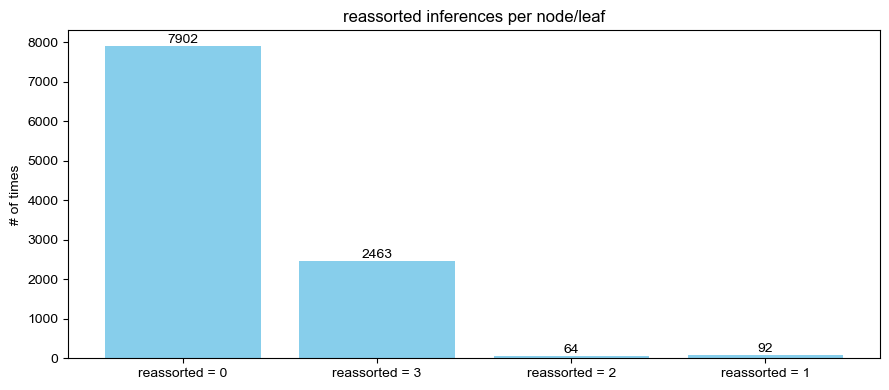

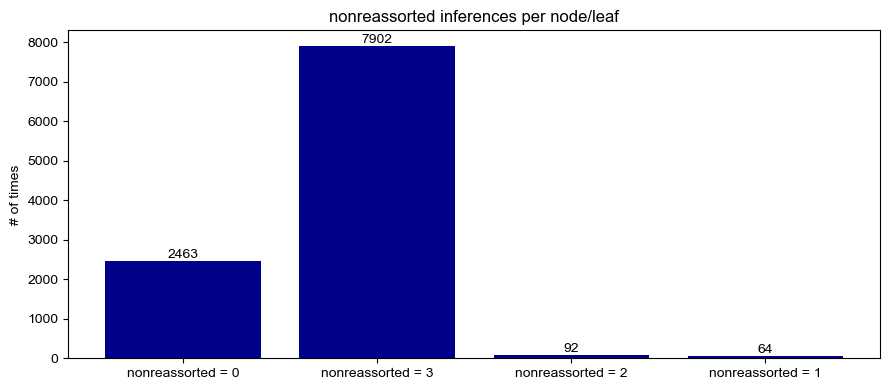

In [40]:
# quick viz of how reassortment events are being inferred

reassorted_counts = Counter()

for node_data in node_annotations_summary.values():
    reassorted = node_data['reassorted']
    reassorted_counts[reassorted] += 1

x_vals = [0, 3, 2, 1]
y_vals = [reassorted_counts.get(x, 0) for x in x_vals]

plt.figure(figsize=(9, 4))
bars = plt.bar([f'reassorted = {x}' for x in x_vals], y_vals, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), 
             ha='center', va='bottom', fontsize=10)

plt.title('reassorted inferences per node/leaf')
plt.ylabel('# of times')
plt.savefig("plots/reassorted_node_leaf_counts.pdf")
plt.tight_layout()
plt.show()

nonreassorted_counts = Counter()

for node_data in node_annotations_summary.values():
    nonreassorted = node_data['nonreassorted']
    nonreassorted_counts[nonreassorted] += 1

x_vals = [0, 3, 2, 1]
y_vals = [nonreassorted_counts.get(x, 0) for x in x_vals]


plt.figure(figsize=(9, 4))
bars = plt.bar([f'nonreassorted = {x}' for x in x_vals], y_vals, color='darkblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), 
             ha='center', va='bottom', fontsize=10)

plt.title('nonreassorted inferences per node/leaf')
plt.ylabel('# of times')
plt.savefig("plots/nonreassorted_node_leaf_counts.pdf")
plt.tight_layout()
plt.show()



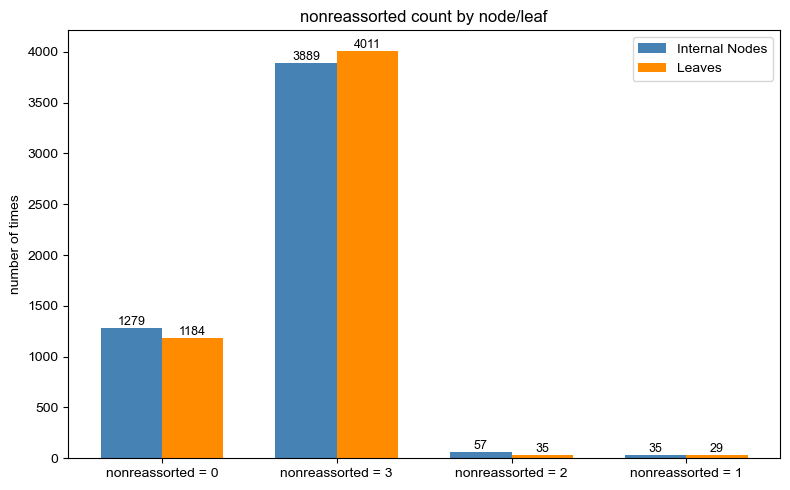

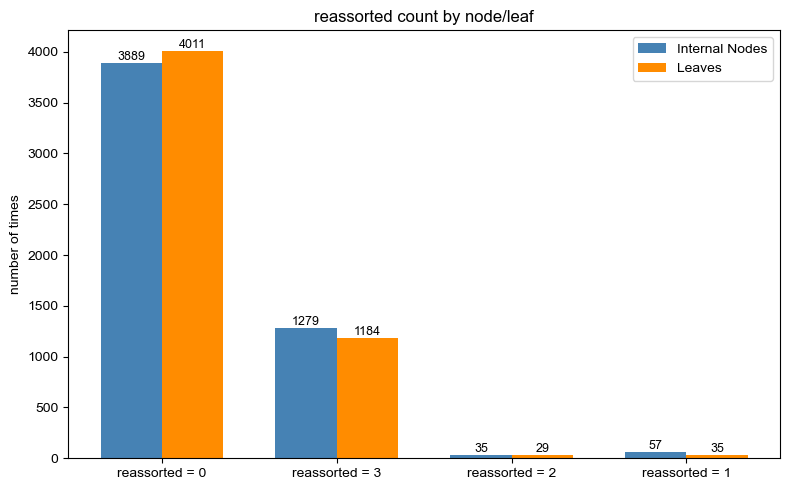

In [41]:
# quick viz of how reassortment events are being inferred separated into nodes/leaves

node_counts = Counter()
leaf_counts = Counter()

node_rea_counts = Counter()
leaf_rea_counts = Counter()

for name, data in node_annotations_summary.items():
    nonreassorted = data['nonreassorted']
    reassorted = data['reassorted']
    if isinstance(name, str):
        if name.startswith('NODE_'):
            node_counts[nonreassorted] += 1
            node_rea_counts[reassorted] += 1
        elif name.lower().startswith('\'a/'):
            leaf_counts[nonreassorted] += 1
            leaf_rea_counts[reassorted] += 1

# X axis values
x_vals = [0, 3, 2, 1]
x_labels = [f'nonreassorted = {x}' for x in x_vals]

node_y = [node_counts.get(x, 0) for x in x_vals]
leaf_y = [leaf_counts.get(x, 0) for x in x_vals]

x = range(len(x_vals))
width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - width/2 for i in x], node_y, width=width, label='Internal Nodes', color='steelblue')
bars2 = plt.bar([i + width/2 for i in x], leaf_y, width=width, label='Leaves', color='darkorange')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=9)

plt.xticks(x, x_labels)
plt.ylabel('number of times')
plt.title('nonreassorted count by node/leaf')
plt.legend()
plt.savefig("plots/nonreassorted_node_leaf_sep_counts.pdf")
plt.tight_layout()
plt.show()


x_labels = [f'reassorted = {x}' for x in x_vals]

node_y = [node_rea_counts.get(x, 0) for x in x_vals]
leaf_y = [leaf_rea_counts.get(x, 0) for x in x_vals]

x = range(len(x_vals))
width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - width/2 for i in x], node_y, width=width, label='Internal Nodes', color='steelblue')
bars2 = plt.bar([i + width/2 for i in x], leaf_y, width=width, label='Leaves', color='darkorange')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=9)

plt.xticks(x, x_labels)
plt.ylabel('number of times')
plt.title('reassorted count by node/leaf')
plt.legend()
plt.tight_layout()
plt.savefig("plots/reassorted_node_leaf_sep_counts.pdf")
plt.show()


In [9]:
print(reassorted_counts)

Counter({0: 7902, 2: 1308, 3: 1219, 1: 92})


In [42]:
# dendropy doesnt have a good viz tool so have to use baltic

def plot_rea(mytree):
    
    plt.rcParams["font.family"] = "Arial"

    fig, ax = plt.subplots(figsize=(15, 15))

    x_attr = lambda k: k.x
    
    color_by = lambda k: "red" if k.traits["is_reassorted"] else "black"

    mytree.plotTree(ax, x_attr=x_attr,colour=color_by, width = 3)
    
    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size= 5,
                   colour=color_by,
                   zorder=2,
                   marker='o'
                     )
    
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', label='Reassorted'),
        Patch(facecolor='black', edgecolor='black', label='Non-reassorted')
    ]
    ax.legend(handles=legend_elements, loc='lower left', fontsize=25, title_fontsize=30)


    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x',labelsize=30,size=15, width=2,color='grey')
    ax.set_xlabel("Divergence", fontsize=25)
    fig.tight_layout()
     
    plt.savefig("plots/rea.pdf")
    plt.show()

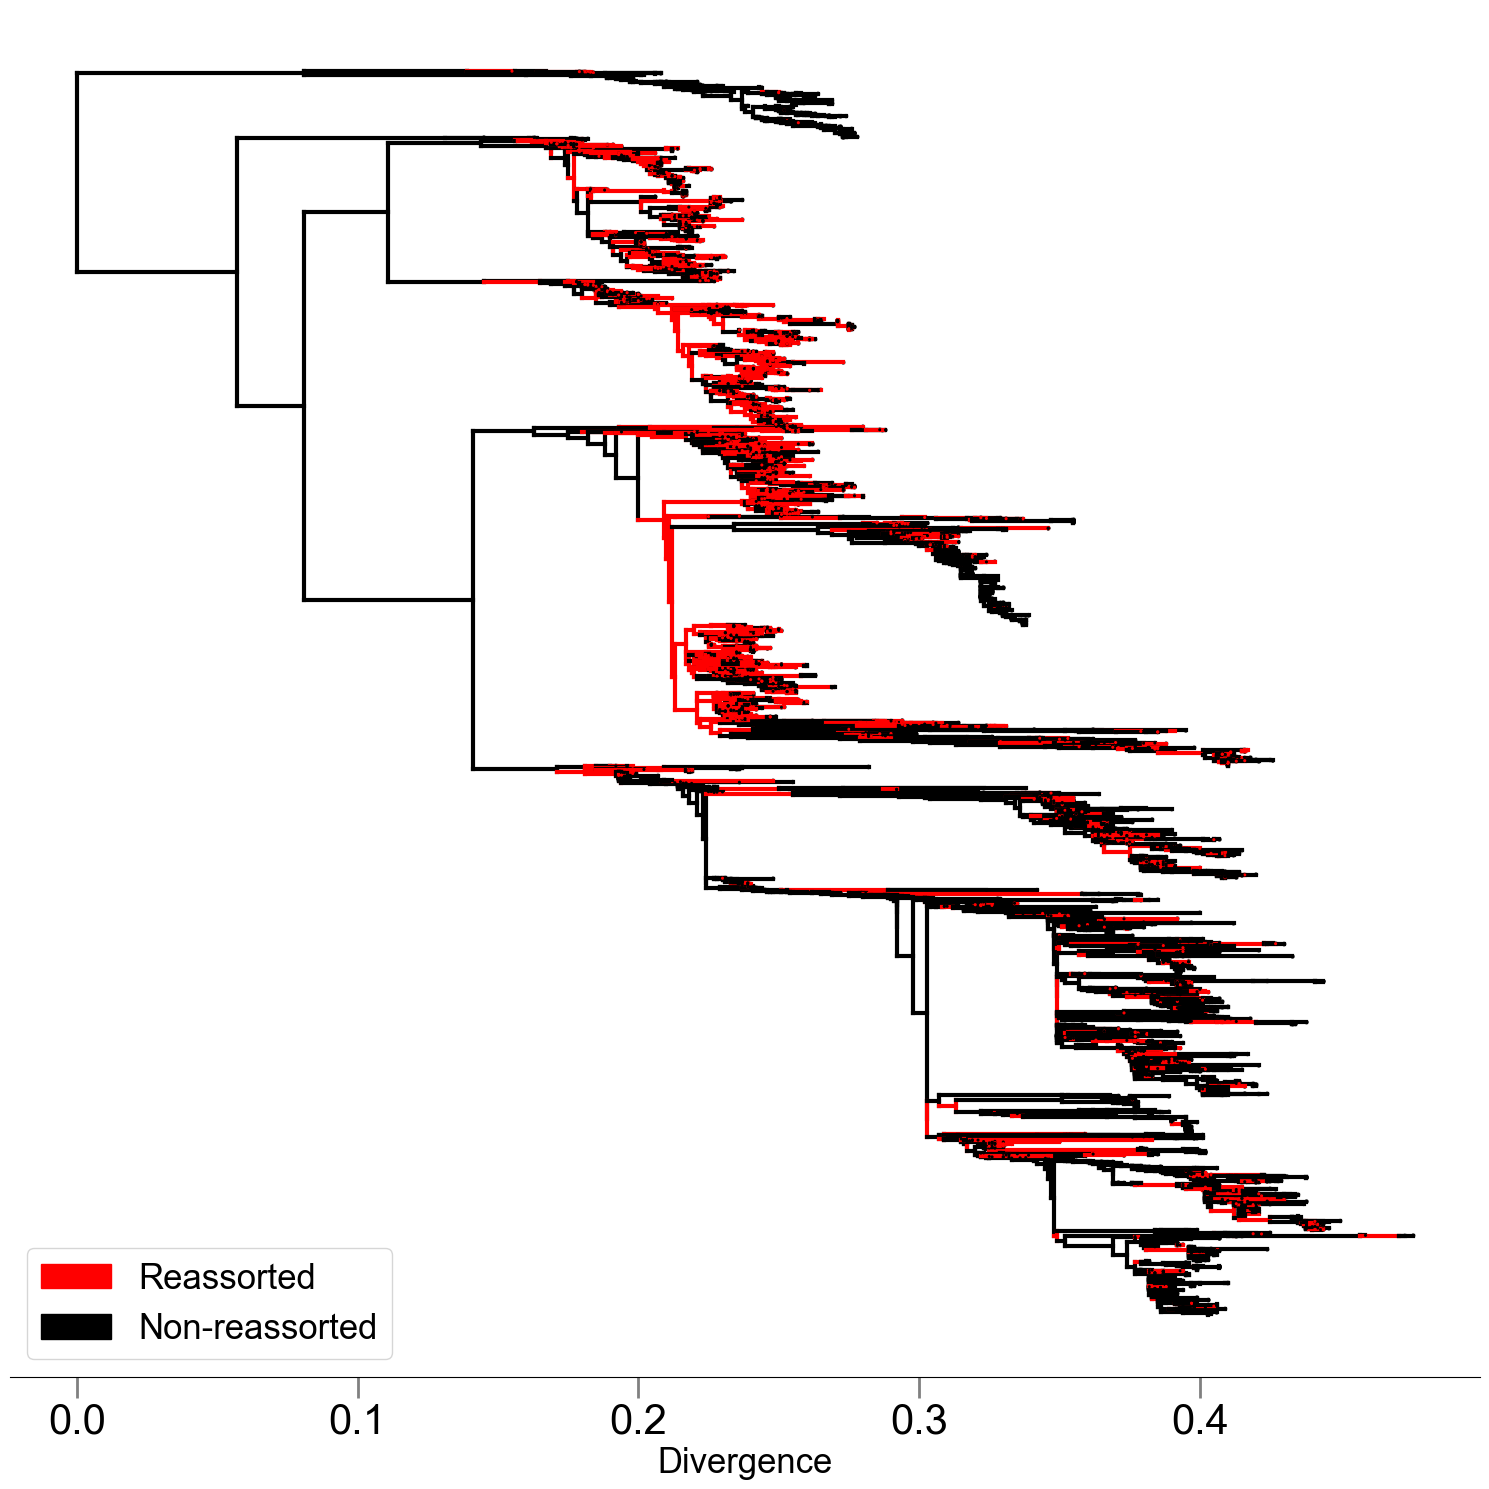

In [43]:
mytree = bt.loadNewick('prepped/div/outputs/output3_summary.nwk', absoluteTime= False)
plot_rea(mytree)